# Домашнее задание 2: Построение простого классификатора изображений

Цель: Изучить применение методов машинного обучения для классификации изображений, сравнить эффективность классических алгоритмов и нейронных сетей.

## Импорты и вспомогательные функции

In [2]:
import os
import pickle
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from typing import Union

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torchvision.transforms as tfs
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

Напишем 2 вспомогательные функции для вывода метрик классификации и отображения примеров изображений с предсказанными и истинными классами.

In [3]:
def print_classification_metrics(
        y_true: Union[list, np.ndarray, torch.Tensor], 
        y_pred: Union[list, np.ndarray, torch.Tensor], 
        label_names: Union[list, np.ndarray, torch.Tensor]
):
    """ Рассчитывает метрики классификации accuracy, precision, recall, f1-score 
    и рассчитывает confusion matrix, результаты выводит на печать. """    

    # расчет и вывод accuracy, precision, recall, f1-score
    class_report = classification_report(y_true, y_pred, target_names=label_names)
    print(class_report)

    # расчет и отображение confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.show()


def show_random_predictions(
        images: Union[np.ndarray, torch.Tensor],
        labels: Union[list, np.ndarray, torch.Tensor],
        preds: Union[list, np.ndarray, torch.Tensor],
        n_samples: int,
        label_names: Union[list, np.ndarray]
):
    """ Отображает n_samples примеров изображений, предсказанный класс и истинный класс. """

    if isinstance(labels, list):
        labels = np.array(labels)
    if isinstance(preds, list):
        preds = np.array(preds)

    # случайный выбор n_samples изображений из набора
    indices = np.random.choice(np.arange(len(images)), n_samples, replace=False)
    samples = images[indices]
    true_labels = labels[indices]
    pred_labels = preds[indices]

    # построение визуализации
    nrows = (n_samples // 10) + (n_samples % 10 != 0)
    ncols = 10 if n_samples > 10 else n_samples
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5))
    for ax, sample, true_label, pred_label in zip(axes.flatten(), samples, true_labels, pred_labels):
        if len(sample.shape) != 3:
            # (3072,) -> (32, 32, 3)
            ax.imshow(sample.reshape(3, 32, 32).transpose(1,2,0))
        else:
            ax.imshow(sample)
        ax.set_title(f'Pred: {label_names[pred_label]}\nTrue: {label_names[true_label]}')
    for ax in axes.flatten():
        ax.set_axis_off()

## Подготовка данных

В рамках этого домашнего задания выберем набор данных CIFAR-10 для классификации объектов в цветных изображениях. Всего датасет состоит из 60000 изображений, каждое из которых принадлежит одному из 10 классов.

В папке с датасетом лежат:
- 5 тренировочных батчей данных по 10000 изображений в каждом
- 1 тестовый батч из 10000 изображений

Таким образом, в исходном датасете уже соблюдена пропорция 80% обучающих и 20% тестовых данных.

In [4]:
# папка с бинарными файлами
directory = 'data/cifar-10-batches-py'

# читаем каждый файл и собираем обучающую выборку в один массив
train_images = []
train_labels = []
for i in range(1, 6):
    path = os.path.join(directory, f'data_batch_{i}')
    with open(path, 'rb') as file:
        data = pickle.load(file, encoding='bytes')

    batch_images = data[b'data']
    train_images.append(batch_images)
    batch_labels = np.array(data[b'labels'])
    train_labels.append(batch_labels)
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

# читаем файл и собираем тестовую выборку
path = os.path.join(directory, 'test_batch')
with open(path, 'rb') as file:
    data = pickle.load(file, encoding='bytes')
test_images = data[b'data']
test_labels = np.array(data[b'labels'])

# выводим размеры обучающей и тестовой выборок
n_classes = 10
print(f'Размер обучающей выборки: {train_images.shape}')
print(f'Размер тестовой выборки: {test_images.shape}')

Размер обучающей выборки: (50000, 3072)
Размер тестовой выборки: (10000, 3072)


In [5]:
# соответствие меток классам
with open('data/cifar-10-batches-py/batches.meta', 'rb') as file:
    labels_info = pickle.load(file)

for k, v in labels_info.items():
    print(f'{k}: {v}')

num_cases_per_batch: 10000
label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_vis: 3072


## Классификация с помощью kNN

Будем использовать реализацию алгоритма из библиотеки `sklearn`: класс `KNeighborsClassifier`.

### kNN на данных исходной размерности

Вызовем конструктор класса `KNeighborsClassifier` с параметром `n_neighbors=5`, то есть класс нового объекта будет определяться на основе 5 ближайших к нему объектов из обучающей выборки. Размерность данных оставим исходной, т.е. равной 3072.

В метод `.fit()` передадим обучающую выборку с соответствующими метками классов.

Для получения предсказаний в метод `.predict()` передадим тестовую выборку. Метрики качества классификации отобразим вспомогательной функцией `print_classification_metrics()`.

              precision    recall  f1-score   support

    airplane       0.38      0.54      0.45      1000
  automobile       0.65      0.20      0.31      1000
        bird       0.23      0.45      0.30      1000
         cat       0.29      0.22      0.25      1000
        deer       0.24      0.51      0.33      1000
         dog       0.39      0.22      0.28      1000
        frog       0.35      0.25      0.29      1000
       horse       0.68      0.21      0.32      1000
        ship       0.40      0.66      0.50      1000
       truck       0.70      0.14      0.23      1000

    accuracy                           0.34     10000
   macro avg       0.43      0.34      0.33     10000
weighted avg       0.43      0.34      0.33     10000



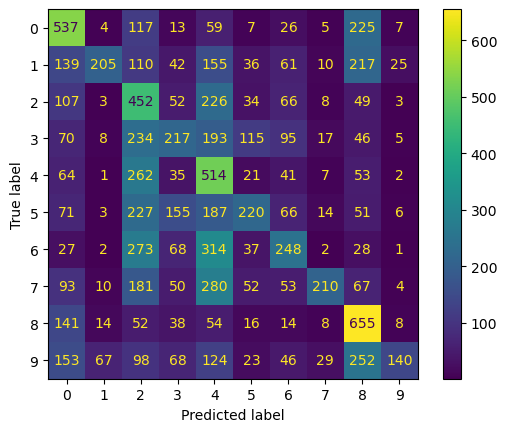

In [10]:
# обучение классификатора
clf_1 = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
clf_1.fit(train_images, train_labels)

# получение предсказаний
test_pred_1 = clf_1.predict(test_images)
print_classification_metrics(test_labels, test_pred_1, labels_info['label_names'])

Получили, что **accuracy** такой модели составляет 34%. Некоторые классы удается классифицировать лучше других.

Топ-3 класса по метрике **precision**: truck, horse, automobile.

Топ-3 класса по метрике **recall**: ship, airplane, deer.

Топ-3 класса по метрике **f1-score**: ship, airplane, deer.

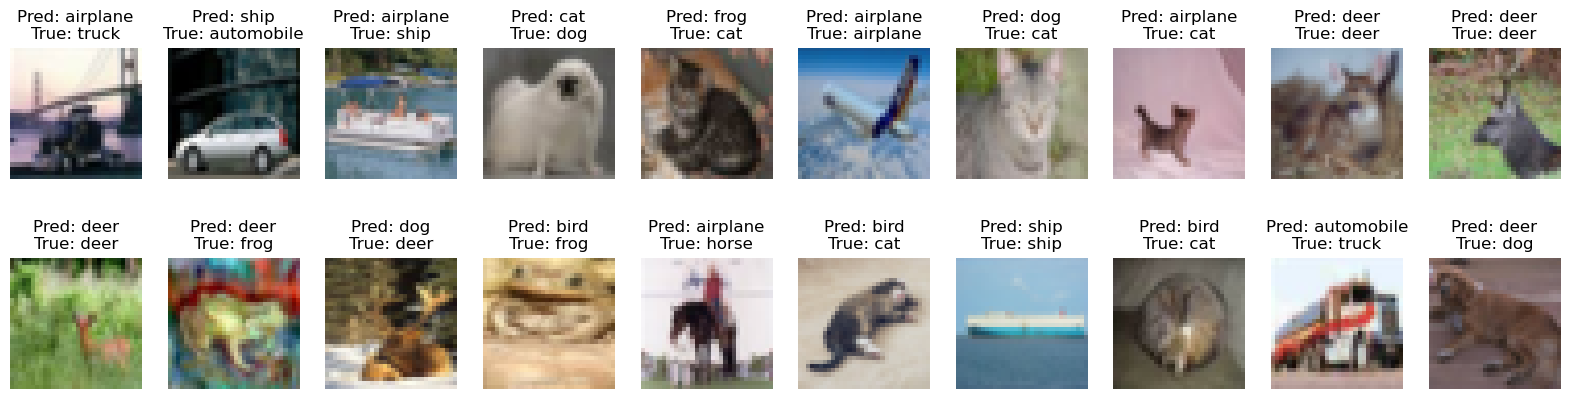

In [11]:
# случаные примеры
show_random_predictions(test_images, test_labels, test_pred_1, 20, labels_info['label_names'])

### kNN на данных уменьшенной размерности с помощью PCA

Исходные данные обладают довольно большой размерностью: 3072 признака (по 3 значения интенсивности R, G, B каналов на каждый пиксель). Это влияет на скорость вычисления расстояния между объектами и вызывает проклятие размерности.

Воспользуемся методом главных компонент для снижения размерности.

Для удобства все преобразования над данными обернем в `Pipeline` из `sklearn`, у этого класса также есть методы `.fit()` и `.predict()`. 
- Первым шагом пайплайна будет `PCA`: в его конструктор класса передадим параметр `n_components=128`, т.е. размерность преобразованного пространства признаков будет равна 128.
- Вторым шагом пайплайна будет алгоритм `kNN`.

Далее у `Pipeline` вызовем метод `.fit()` и передадим в него обучающую выборку, а затем `.predict()` для вычисления предсказаний. 

              precision    recall  f1-score   support

    airplane       0.38      0.57      0.46      1000
  automobile       0.64      0.30      0.41      1000
        bird       0.25      0.46      0.32      1000
         cat       0.31      0.20      0.24      1000
        deer       0.27      0.49      0.34      1000
         dog       0.46      0.25      0.32      1000
        frog       0.34      0.38      0.36      1000
       horse       0.66      0.27      0.38      1000
        ship       0.46      0.63      0.53      1000
       truck       0.73      0.22      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.45      0.38      0.37     10000
weighted avg       0.45      0.38      0.37     10000



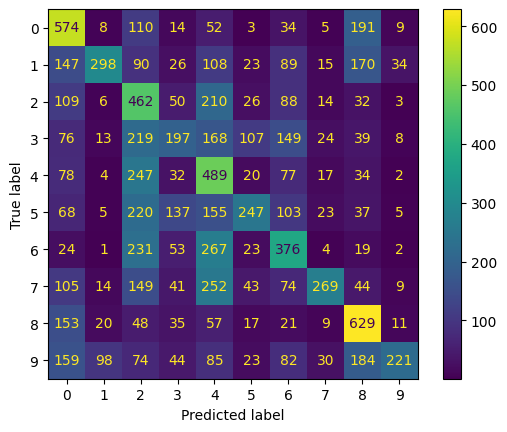

In [6]:
# создание пайплайна
clf_2 = Pipeline([
    ('pca', PCA(n_components=128)),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

# обучение классификатора
clf_2.fit(train_images, train_labels)

# получение предсказаний
test_pred_2 = clf_2.predict(test_images)
print_classification_metrics(test_labels, test_pred_2, labels_info['label_names'])

Видим, что использование `PCA` позволило немного улучшить качество классификации.

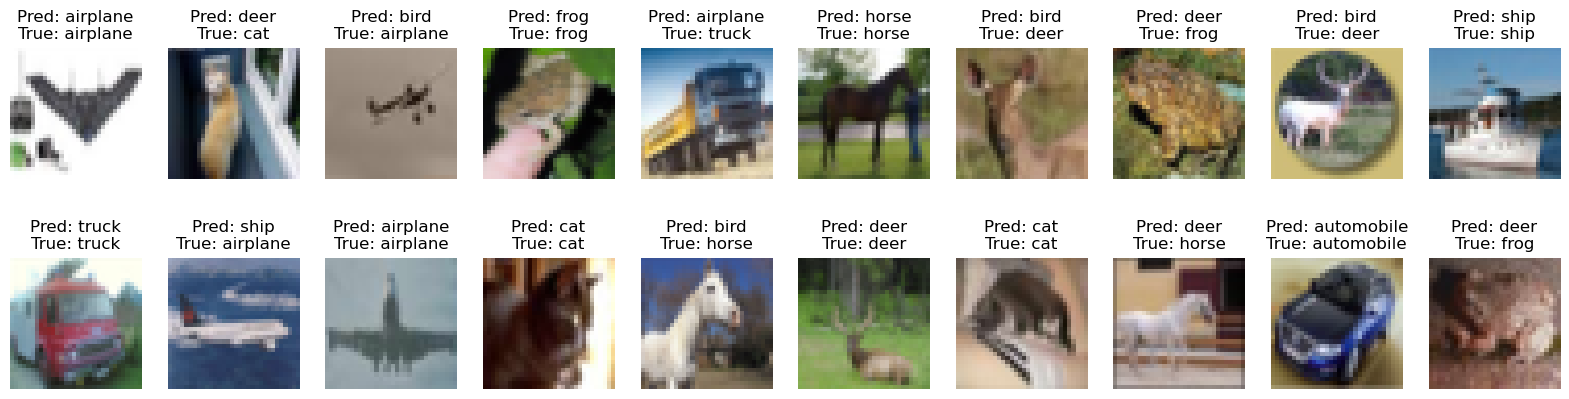

In [13]:
# случаные примеры
show_random_predictions(test_images, test_labels, test_pred_2, 20, labels_info['label_names'])

### Стандартизация + PCA + kNN

Перед понижением размерности применим стандартизацию, используя `StandardScaler` из `sklearn`. Благодаря этому преобразованию среднее каждого признака станет равным 0, а стандартное отклонение - равным 1.

Затем, аналогично предыдущему варианту, уменьшим размерность пространства до 128 с помощью `PCA` и обучим `kNN` на данных уменьшенной размерности.

              precision    recall  f1-score   support

    airplane       0.40      0.58      0.47      1000
  automobile       0.65      0.30      0.41      1000
        bird       0.25      0.45      0.32      1000
         cat       0.31      0.21      0.25      1000
        deer       0.26      0.49      0.34      1000
         dog       0.45      0.24      0.31      1000
        frog       0.35      0.38      0.36      1000
       horse       0.65      0.26      0.38      1000
        ship       0.45      0.62      0.52      1000
       truck       0.74      0.22      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.45      0.38      0.37     10000
weighted avg       0.45      0.38      0.37     10000



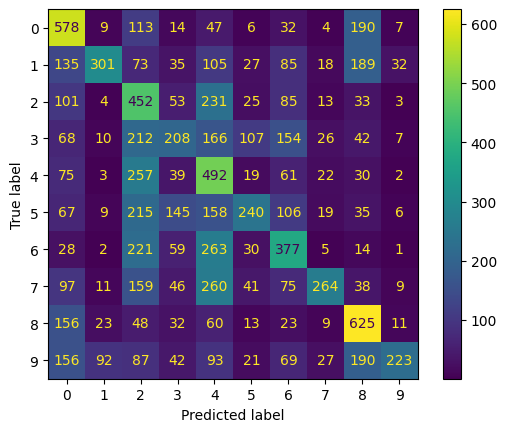

In [7]:
# создание пайплайна
clf_3 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=128)),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

# обучение классификатора
clf_3.fit(train_images, train_labels)

# получение предсказаний
test_pred_3 = clf_3.predict(test_images)
print_classification_metrics(test_labels, test_pred_3, labels_info['label_names'])

Полученные результаты тоже лучше самого первого подхода и почти эквивалентны второму подходу.

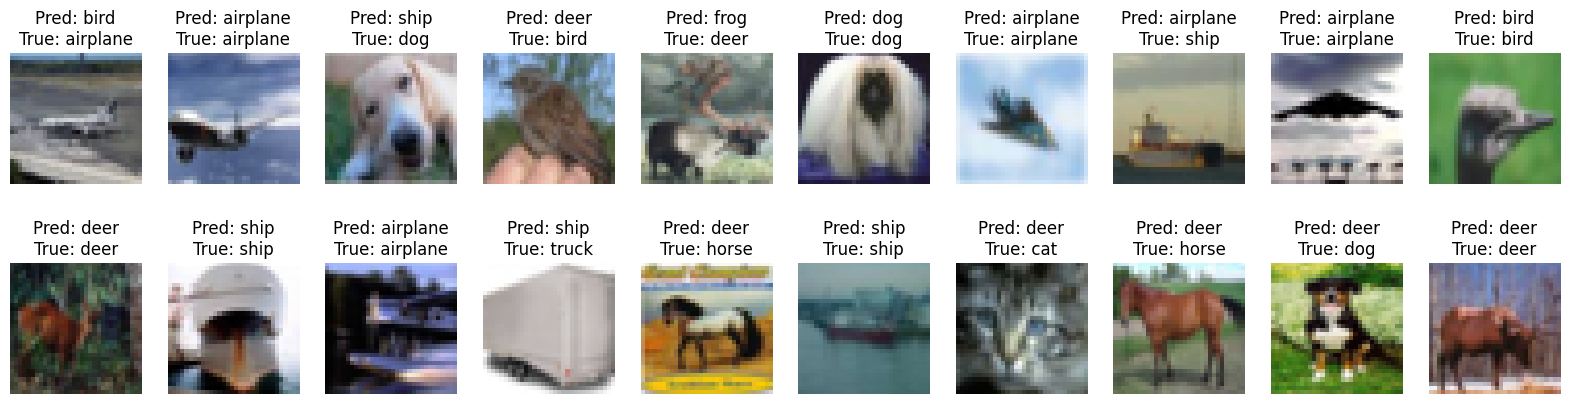

In [8]:
# случаные примеры
show_random_predictions(test_images, test_labels, test_pred_2, 20, labels_info['label_names'])

### GridSearch для поиска наилучшей комбинации гиперпараметров

Сделаем дополнительно поиск наилучшей комбинации гиперпараметров при помощи `GridSearch`. Для этого создадим сетку параметров:
- переберем 3 значения `n_components` для метода `PCA`: 64, 128, 256.
- и 3 значения `n_neighbors` для алгоритма `kNN`: 5, 10, 15.

Инициализируем `GridSearch`, указав количество фолдов для кроссвалидации `cv=3` и метрику `scoring='accuracy'`.

In [17]:
# создание пайплайна
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# параметры поиска
params_grid = {
    'pca__n_components': [64, 128, 256],
    'knn__n_neighbors': [5, 10, 15]
}

grid_search = GridSearchCV(clf, params_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=10)
grid_search.fit(train_images, train_labels)
print(grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'knn__n_neighbors': 10, 'pca__n_components': 64}


Получили следующие наилучшие параметры в заданной сетке:
- число компонент для `PCA`: `n_components=64`
- число соседей для `kNN`: `n_neighbors=10` 

Используем классификатор с наилучшими параметрами для получения предсказаний и оценки качества классификации на тестовой выборке.

              precision    recall  f1-score   support

    airplane       0.46      0.59      0.51      1000
  automobile       0.66      0.34      0.45      1000
        bird       0.26      0.43      0.32      1000
         cat       0.33      0.20      0.25      1000
        deer       0.27      0.48      0.35      1000
         dog       0.50      0.25      0.33      1000
        frog       0.36      0.49      0.41      1000
       horse       0.65      0.30      0.41      1000
        ship       0.47      0.66      0.55      1000
       truck       0.72      0.28      0.40      1000

    accuracy                           0.40     10000
   macro avg       0.47      0.40      0.40     10000
weighted avg       0.47      0.40      0.40     10000



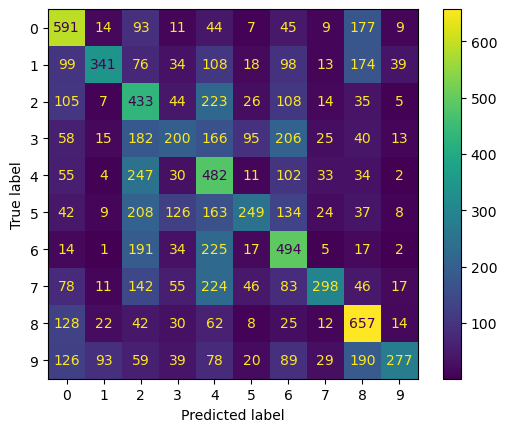

In [21]:
# получение предсказаний
clf_4 = grid_search.best_estimator_
test_pred_4 = clf_4.predict(test_images)
print_classification_metrics(test_labels, test_pred_4, labels_info['label_names'])

Видим, что полученная модель немного превосходит по качеству варианты классификаторов 2 и 3.

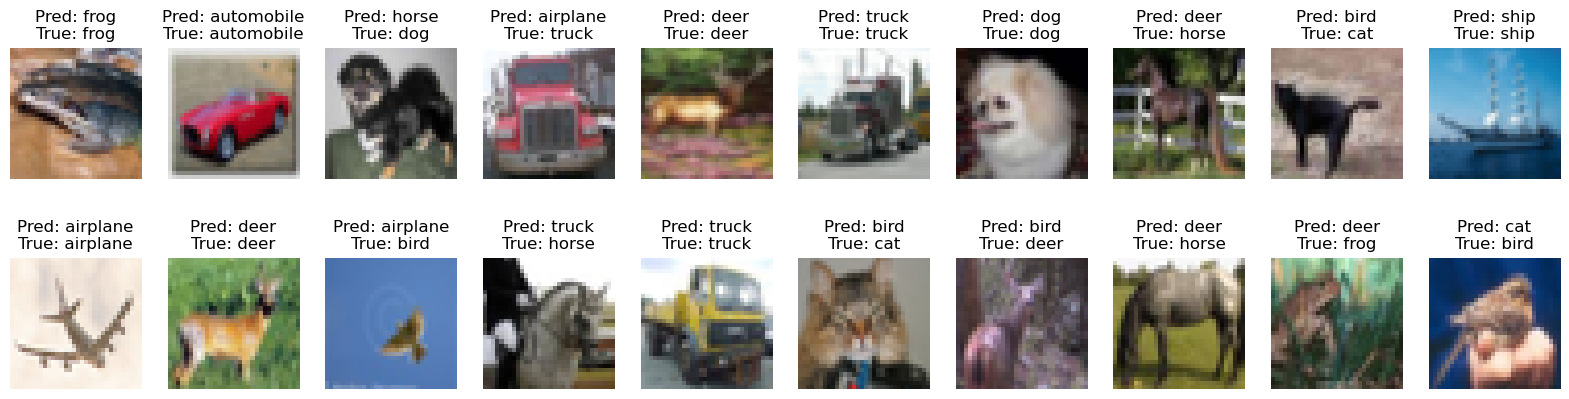

In [22]:
# случаные примеры
show_random_predictions(test_images, test_labels, test_pred_4, 20, labels_info['label_names'])

## Классификация с помощью MLP

Для реализации многослойного перцептрона будем использовать фреймворк PyTorch.

### Datasets and DataLoaders

Подготовим обучающую и тестовую выборки. Сначала зададим трансформации над изображениями. Для этого используем модуль `torchvision.transforms`.
- `torchvision.transforms.Compose()` - позволяет удобно строить последовательности преобразований.
- `torchvision.transforms.ToTensor()` - конвертирует входной объект (PIL-изображение или numpy-массив) в тензор и приводит его к диапазону [0, 1].
- `torchvision.transforms.Normalize()` - нормализует каждый канал входного тензора, используя заданные средние и стандартные отклонения.

Используем класс `CIFAR10` из модуля `torchvision.datasets` для определения обучающего (параметр `train=True`) и тестового (параметр `train=False`) датасетов.

Создадим даталоадеры для загрузки данных при помощи класса `DataLoader` из модуля `torch.utils.data`. Передадим в соответствующие конструкторы обучающий и тестовый датасеты, размер батча `batch_size=128` и количество воркеров для паралелльной загрузки данных `num_workers=4`. Для `train_loader` укажем `shuffle=True` - это значит, что во время обучения данные будут перемешиваться и подаваться на вход нейронной сети в случайном порядке. Для `test_loader` укажем `shuffle=False`.

In [11]:
# преобразования над изображениями
transform = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# обучающая и тестовая выборки
train_dataset = CIFAR10('data', train=True, transform=transform, download=True)
test_dataset = CIFAR10('data', train=False, transform=transform, download=True)

# обучающий и тестовый даталоадеры
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### Архитектуры

Создадим для экспериментов 2 архитектуры MLP.

1. `MLPClassifier1` - состоит из 1 входного слоя, 2 скрытых линейных слоев и 1 выходого линейного слоя. Между слоями используется функция активации ReLU.

2. `MLPClassifier2` - аналогично, состоит из 1 входного слоя, 2 скрытых линейных слоев, 1 выходого линейного слоя и функции активации ReLU между слоями. Однако, дополнительно здесь добавлены методы регуляризации: батч-нормализация и дропаут.

Обе архитектуры реализованы в виде классов, наследующихся от `torch.nn.Module`. В методе `__init__` задаются необходимые преобразования (слои, функции активации, нормализации, дропауты и т.д.), а в методе `forward` указывается собственно последовательность преобразований над входными данными.

In [ ]:
class MLPClassifier1(nn.Module):
    """ Классификатор архитектуры MLP с 2 скрытыми линейными слоями и 1 выходным линейным слоем. """

    def __init__(self, input_dim: int, hidden_dim: int, n_classes: int):
        super().__init__()

        self.flatten = nn.Flatten()  # (N, C, H, W) -> (N, C*H*W) - вытягивает каждую картинку в вектор
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class MLPClassifier2(nn.Module):
    """ Классификатор архитектуры MLP с 2 скрытыми линейными слоями, 1 выходным линейным слоем,
    batch-нормализацией и дропаутом. """

    def __init__(self, input_dim: int, hidden_dim: int, n_classes: int):
        super().__init__()

        self.flatten = nn.Flatten()  # (N, C, H, W) -> (N, C*H*W) - вытягивает каждую картинку в вектор
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout()
        )
        self.layer3 = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

### Функции обучения, предсказания и отрисовки графиков

Напишем следующие функции:
- `train()` - производит обучение модели в течение заданного числа эпох. В качестве параметров принимает модель, обучающий даталоадер, тестовый даталоадер, число эпох, функцию потерь, оптимизатор и частоту вывода логов (значений лосса и точности для текущей эпохи).
- `predict()` - вычисляет предсказания модели для заданной выборки. В качестве параметров принимает модель и даталоадер с нужными данными.
- ``

In [ ]:
def train(model, train_loader, test_loader, epochs, criterion, optimizer, log_freq=10):
    """ Производит обучение модели. """

    # кладем модель на нужное устройство
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    train_loss, test_loss = [], []
    train_accuracy, test_accuracy = [], []

    # цикл обучения
    for epoch in tqdm(range(epochs)):
        
        # training
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()  # переводим модель в режим обучения
        for batch, labels in train_loader:
            # кладем данные на нужное устройство
            batch = batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # обнуляем градиенты

            logits = model(batch)  # вычисляем выходы модели
            preds = torch.argmax(logits, dim=1)  # получаем предсказания (метки классов)
            loss = criterion(logits, labels)  # вычисляем значение лосса
            loss.backward()  # считаем градиенты по весам

            optimizer.step()  # делаем шаг метода оптимизации

            # сохраняем значения лосса и точности на обучающих батчах
            epoch_loss += loss.item()
            correct = torch.eq(labels, preds).sum().item()
            epoch_accuracy += correct / len(preds)

        train_loss.append(epoch_loss / len(train_loader))
        train_accuracy.append(epoch_accuracy / len(train_loader))

        # evaluation
        epoch_loss = 0
        epoch_accuracy = 0
        model.eval()  # переводим модель в режим валидации
        with torch.no_grad():
            for batch, labels in test_loader:
                # кладем данные на нужное устройство
                batch = batch.to(device)
                labels = labels.to(device)

                logits = model(batch)  # вычисляем выходы модели 
                preds = torch.argmax(logits, dim=1)  # получаем предсказания (метки классов)
                loss = criterion(logits, labels)  # вычисляем значение лосса

                # сохраняем значения лосса и точности на тестовых батчах
                epoch_loss += loss.item()
                correct = torch.eq(labels, preds).sum().item()
                epoch_accuracy += correct / len(preds)

        test_loss.append(epoch_loss / len(test_loader))
        test_accuracy.append(epoch_accuracy / len(test_loader))

        # logging
        if epoch % log_freq == 0:
            print(f""" Epoch {epoch}:
            \t Train loss = {train_loss[-1]:.4f}, train acc = {train_accuracy[-1]:.4f}
            \t Test loss = {test_loss[-1]:.4f}, test acc = {test_accuracy[-1]:.4f}""")

    # формируем словарь с динамикой обучения по эпохам
    log_dict = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }
    return log_dict


def predict(model, dataloader):
    """ Вычисляет предсказания для заданного набора данных. """

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    preds = []
    model.eval()
    with torch.no_grad():
        for batch, _ in dataloader:
            batch = batch.to(device)
            logits = model(batch)
            batch_preds = torch.argmax(logits, dim=1)
            preds.append(batch_preds)
    return torch.cat(preds).cpu()


def plot_training_dynamics(log_dict):
    """ Отрисовывает графики изменения лосса и точности на обучающей и тестовой выборках. """

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Training dynamics')

    axes[0].plot(log_dict['train_loss'], label='train')
    axes[0].plot(log_dict['test_loss'], label='test')
    axes[0].legend()
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(log_dict['train_accuracy'], label='train')
    axes[1].plot(log_dict['test_accuracy'], label='test')
    axes[1].legend()
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')

    fig.show()

### MLP

Обучим в течение 200 эпох классификатор `MLPClassifier1` со 128 нейронами в скрытых слоях.

В качестве функции потерь будем использовать кросс-энтропию, так как мы решаем задачу многоклассовой классификации. `nn.CrossEntropyLoss()` внутри себя вызывает log-softmax, поэтому при создании архитектуры нейронной сети нам не нужно нормировать данные и вычислять вероятности классов.

В качестве оптимизатора используем стохастический градиентный спуск `SGD`, скорость обучения установим равной 0.001.

  0%|          | 0/200 [00:00<?, ?it/s]

 Epoch 0:
            	 Train loss = 2.2929, train acc = 0.1257
            	 Test loss = 2.2774, test acc = 0.1580
 Epoch 10:
            	 Train loss = 2.0079, train acc = 0.2878
            	 Test loss = 1.9916, test acc = 0.2979
 Epoch 20:
            	 Train loss = 1.8531, train acc = 0.3435
            	 Test loss = 1.8424, test acc = 0.3445
 Epoch 30:
            	 Train loss = 1.7623, train acc = 0.3776
            	 Test loss = 1.7545, test acc = 0.3827
 Epoch 40:
            	 Train loss = 1.6947, train acc = 0.4016
            	 Test loss = 1.6893, test acc = 0.4036
 Epoch 50:
            	 Train loss = 1.6431, train acc = 0.4194
            	 Test loss = 1.6417, test acc = 0.4200
 Epoch 60:
            	 Train loss = 1.6019, train acc = 0.4353
            	 Test loss = 1.6054, test acc = 0.4376
 Epoch 70:
            	 Train loss = 1.5659, train acc = 0.4487
            	 Test loss = 1.5758, test acc = 0.4488
 Epoch 80:
            	 Train loss = 1.5337, train acc = 0.4615


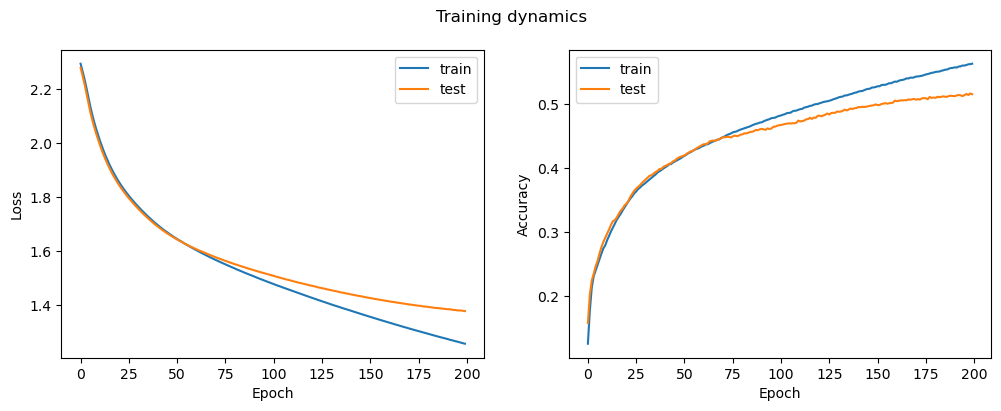

In [18]:
# создание модели
n_classes = 10
input_dim = 32 * 32 * 3
hidden_dim = 128
mlp_1 = MLPClassifier1(input_dim, hidden_dim, n_classes)

# функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_1.parameters(), lr=1e-3)

# обучение модели
log_dict_1 = train(mlp_1, train_loader, test_loader, epochs=200, criterion=criterion, optimizer=optimizer)

# отрисовка графиков
plot_training_dynamics(log_dict_1)

Видим, что в течение обучения лоссы постепенно уменьшаются, а accuracy растут. Примечательно, что начиная примерно со 150 эпохи тестовая accuracy начинает выходить на плато, а тренировочная accuracy продолжает расти. Это может свидетельствовать о том, что целесообразно остановить обучение, чтобы избежать переобучения модели.

              precision    recall  f1-score   support

    airplane       0.60      0.58      0.59      1000
  automobile       0.61      0.64      0.62      1000
        bird       0.42      0.34      0.38      1000
         cat       0.38      0.36      0.37      1000
        deer       0.44      0.39      0.41      1000
         dog       0.43      0.39      0.41      1000
        frog       0.51      0.62      0.56      1000
       horse       0.56      0.60      0.58      1000
        ship       0.60      0.68      0.64      1000
       truck       0.57      0.56      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



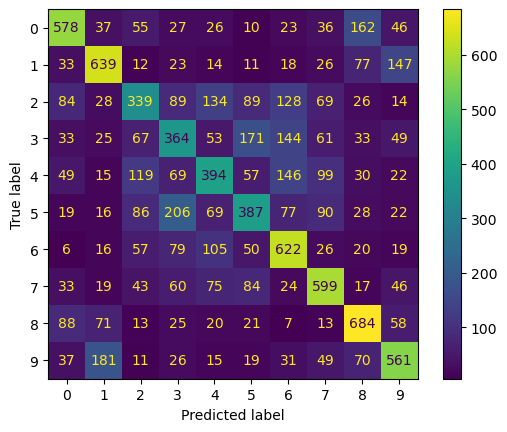

In [19]:
# получение предсказаний
mlp_1_pred = predict(mlp_1, test_loader)
print_classification_metrics(test_dataset.targets, mlp_1_pred, test_dataset.classes)

Метрики качества на тестовой выборке превосходят результаты лучшей реализации классификатора `kNN`.

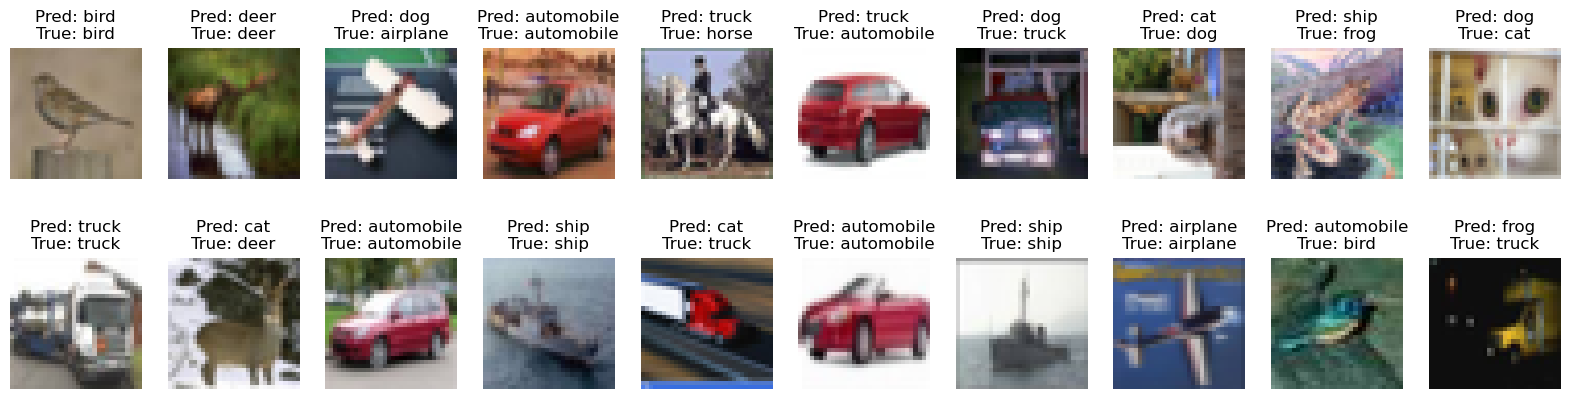

In [20]:
# случаные примеры
show_random_predictions(test_dataset.data, test_dataset.targets, mlp_1_pred, 20, test_dataset.classes)

### MLP + батч-нормализация и дропаут

Обучим в течение 200 эпох классификатор `MLPClassifier2` со 128 нейронами в скрытых слоях.

Аналогично предыдущему варианту, в качестве функции потерь будем использовать кросс-энтропию, а в качестве оптимизатора - стохастический градиентный спуск `SGD`, скорость обучения установим равной 0.001.

  0%|          | 0/200 [00:00<?, ?it/s]

 Epoch 0:
            	 Train loss = 2.2768, train acc = 0.1652
            	 Test loss = 2.0767, test acc = 0.2871
 Epoch 10:
            	 Train loss = 1.8696, train acc = 0.3321
            	 Test loss = 1.7550, test acc = 0.4018
 Epoch 20:
            	 Train loss = 1.7793, train acc = 0.3645
            	 Test loss = 1.6597, test acc = 0.4241
 Epoch 30:
            	 Train loss = 1.7286, train acc = 0.3833
            	 Test loss = 1.6058, test acc = 0.4420
 Epoch 40:
            	 Train loss = 1.6903, train acc = 0.3972
            	 Test loss = 1.5682, test acc = 0.4540
 Epoch 50:
            	 Train loss = 1.6594, train acc = 0.4103
            	 Test loss = 1.5410, test acc = 0.4624
 Epoch 60:
            	 Train loss = 1.6366, train acc = 0.4144
            	 Test loss = 1.5165, test acc = 0.4694
 Epoch 70:
            	 Train loss = 1.6159, train acc = 0.4215
            	 Test loss = 1.4989, test acc = 0.4762
 Epoch 80:
            	 Train loss = 1.6001, train acc = 0.4287


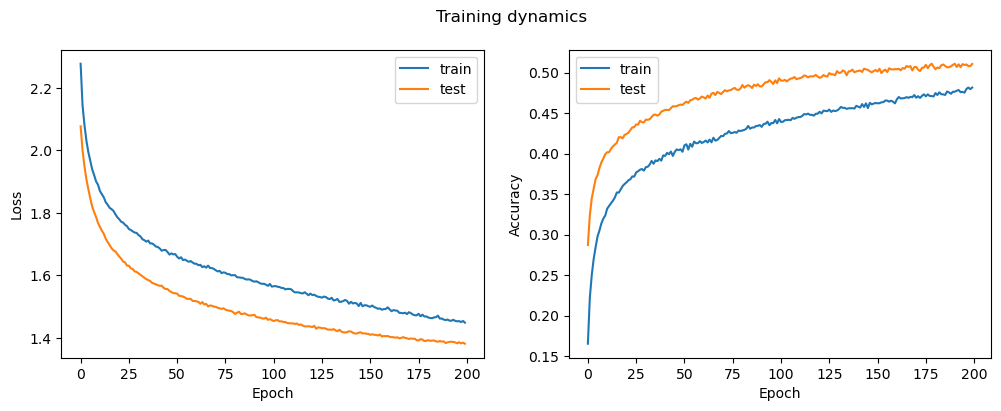

In [21]:
# создание модели
n_classes = 10
input_dim = 32 * 32 * 3
hidden_dim = 128
mlp_2 = MLPClassifier2(input_dim, hidden_dim, n_classes)

# функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp_2.parameters(), lr=1e-3)

# обучение модели
log_dict_2 = train(mlp_2, train_loader, test_loader, epochs=200, criterion=criterion, optimizer=optimizer)

# отрисовка графиков
plot_training_dynamics(log_dict_2)

На графиках изменения лосса и accuracy видим интересное наблюдение: на тестовой выборке лосс меньше, а accuracy больше. Это объясняется использованием дропаута: во время инференса он не применяется.

Также в этом варианте использование батч-нормализации и дропаута способствует чуть более быстрому снижению лосса и более стабильному обучению.

              precision    recall  f1-score   support

    airplane       0.58      0.53      0.56      1000
  automobile       0.61      0.63      0.62      1000
        bird       0.42      0.31      0.35      1000
         cat       0.37      0.27      0.31      1000
        deer       0.44      0.47      0.46      1000
         dog       0.44      0.38      0.41      1000
        frog       0.47      0.68      0.55      1000
       horse       0.55      0.61      0.58      1000
        ship       0.60      0.71      0.65      1000
       truck       0.58      0.52      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



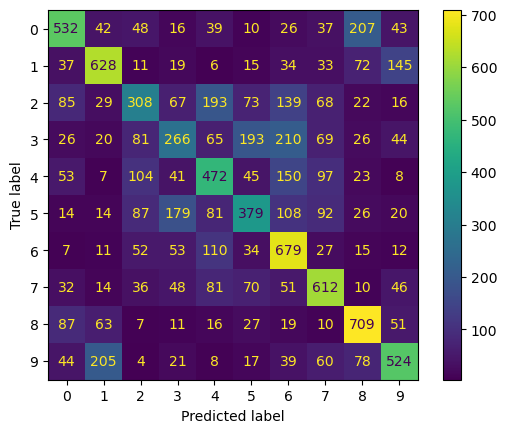

In [22]:
# получение предсказаний
mlp_2_pred = predict(mlp_2, test_loader)
print_classification_metrics(test_dataset.targets, mlp_2_pred, test_dataset.classes)

Метрики качества сопоставимы с результатом работы `MLPClassifier2`.

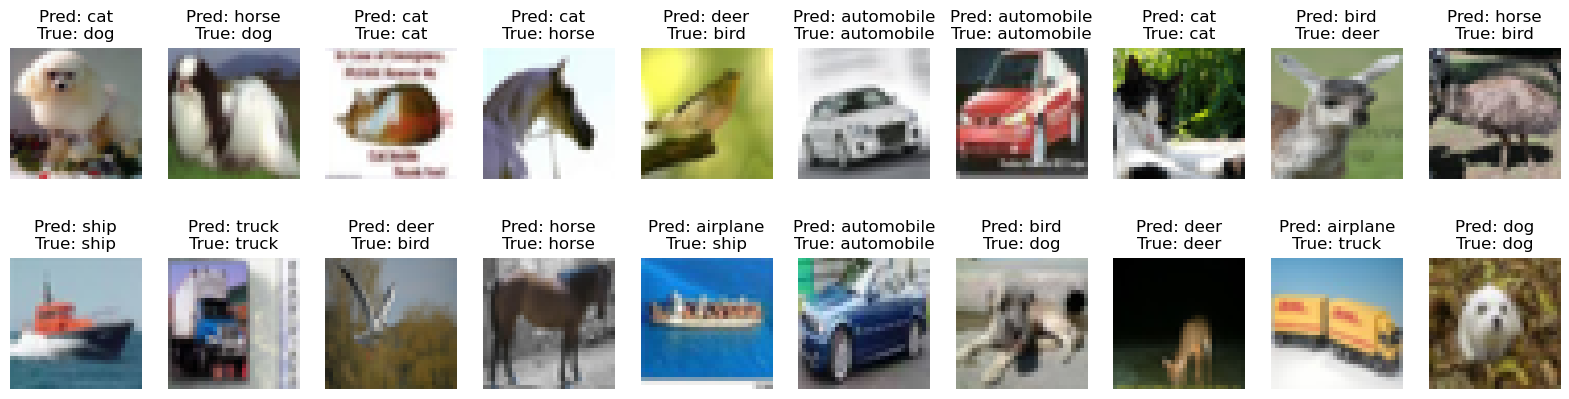

In [23]:
# случаные примеры
show_random_predictions(test_dataset.data, test_dataset.targets, mlp_2_pred, 20, test_dataset.classes)

## Выводы

### Сравнение классических алгоритмов (kNN) и нейронных сетей (MLP)

- kNN просто реализуется и обучается быстрее MLP (в рамках проведенных экспериментов), однако имеет плохую точность предсказаний. Довольно чувствителен к размерности пространства признаков в силу того, что это метрический алгоритм. Неэффективен по памяти, так как хранит все объекты обучающей выборки для вычисления расстояний.

- MLP сложнее в реализации, однако довольно гибок за счет богатого выбора настроек: можно экспериментировать с числом слоев, нейронов, функциями активации и методами регуляризации. Обладает большей точностью, чем классические методы. Дольше учится, так как имеет большое число параметров, зато поддерживает обучение по батчам данных. Вычислительная сложность и число параметров MLP сильно увеличиваются с ростом размерности входных данных: для маленьких картинок 32 х 32 пикселя во входном слое нужно 3072 нейронов, соответственно, для картинок большего разрешения нужно еще больше параметров, что может оказаться очень неэффективно.

### Способы улучшения моделей

- При использовании классических алгоритмов можно попробовать различные способы предобработки исходных данных и методы извлечения признаков.
- При использовании нейронных сетей стоит применить сверточные слои вместо линейных. Такие слои хорошо работают с пространственной информацией, заключенной в картинках. Еще одним путем для улучшения является применение аугментаций над данными, т.е. специальных преобразований, которые немного изменяют исходные картинки и таким образом расширяют обучающий набор. Это способствует борьбе с переобучением.